In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alincijov_self_driving_cars_path = kagglehub.dataset_download('alincijov/self-driving-cars')

print('Data source import complete.')


Data source import complete.


In [ ]:
import pandas as pd

# Load the labels file
labels = pd.read_csv("/kaggle/input/self-driving-cars/labels_trainval.csv")

# Get unique class IDs
unique_classes = labels['class_id'].unique()

# Show the number of unique classes
print(f"Number of unique classes: {len(unique_classes)}")
print("Classes:", unique_classes)


Number of unique classes: 5
Classes: [1 3 2 5 4]


Processed 100 objects
Processed 200 objects
Processed 300 objects
Processed 400 objects
Processed 500 objects
Processed 600 objects
Processed 700 objects
Processed 800 objects
Processed 900 objects
Processed 1000 objects
Processed 1100 objects
Processed 1200 objects
Processed 1300 objects
Processed 1400 objects
Processed 1500 objects
Processed 1600 objects
Processed 1700 objects
Processed 1800 objects
Processed 1900 objects
Processed 2000 objects
Processed 2100 objects
Processed 2200 objects
Processed 2300 objects
Processed 2400 objects
Processed 2500 objects
Processed 2600 objects
Processed 2700 objects
Processed 2800 objects
Processed 2900 objects
Processed 3000 objects
Processed 3100 objects
Processed 3200 objects
Processed 3300 objects
Processed 3400 objects
Processed 3500 objects
Processed 3600 objects
Processed 3700 objects
Processed 3800 objects
Processed 3900 objects
Processed 4000 objects
Processed 4100 objects
Processed 4200 objects
Processed 4300 objects
Processed 4400 objec

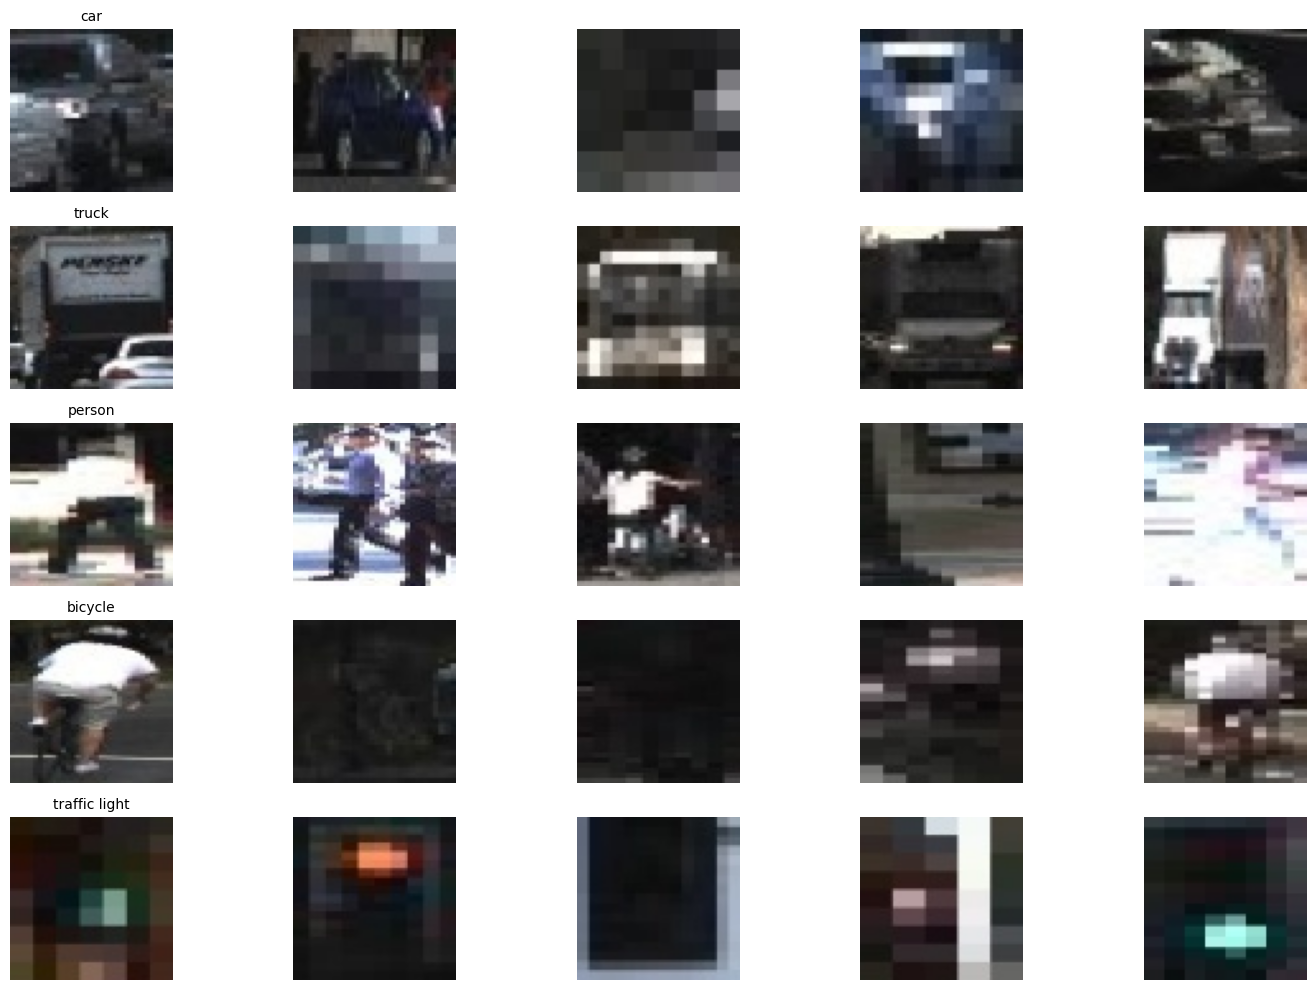


Dataset preparation complete! Ready for quantum ML!


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define class mapping
class_mapping = { 1:'car', 2:'truck', 3:'person', 4:'bicycle', 5:'traffic light'}

def preprocess_dataset(data_dir, labels_path, output_dir, image_size=(64, 64)):
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    for class_name in class_mapping.values():
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

    # Load labels
    df = pd.read_csv(labels_path)

    # Process each frame
    processed_count = 0
    for frame in df['frame'].unique():
        try:
            # Load image
            img_path = os.path.join(data_dir, "images", frame)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not load image: {img_path}")
                continue

            # Get all objects in this frame
            frame_objects = df[df['frame'] == frame]

            # Extract each object
            for _, obj in frame_objects.iterrows():
                xmin, xmax = int(obj['xmin']), int(obj['xmax'])
                ymin, ymax = int(obj['ymin']), int(obj['ymax'])
                class_id = obj['class_id']

                # Skip if class_id not in mapping
                if class_id not in class_mapping:
                    continue

                # Extract object patch
                object_img = img[ymin:ymax, xmin:xmax]
                if object_img.size == 0:
                    continue

                # Resize to small dimensions suitable for quantum ML
                object_img = cv2.resize(object_img, image_size, interpolation=cv2.INTER_AREA)


                # Save processed image
                class_name = class_mapping[class_id]
                output_path = os.path.join(output_dir, class_name, f"{frame.split('.')[0]}_{xmin}_{ymin}.jpg")
                cv2.imwrite(output_path, object_img)
                processed_count += 1

                # Log progress
                if processed_count % 100 == 0:
                    print(f"Processed {processed_count} objects")

        except Exception as e:
            print(f"Error processing frame {frame}: {e}")

    print(f"Total processed objects: {processed_count}")
    return processed_count

def create_dataset_splits(processed_dir, test_size=0.2):
    """
    Create train/test splits and generate CSV files for the processed dataset
    """
    data = []

    # Collect all processed images
    for class_name in class_mapping.values():
        class_dir = os.path.join(processed_dir, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith(('.jpg', '.png')):
                img_path = os.path.join(class_name, img_file)
                class_id = [k for k, v in class_mapping.items() if v == class_name][0]
                data.append({
                    'path': img_path,
                    'class_id': class_id,
                    'class_name': class_name
                })

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Split into train and test
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['class_id'])

    # Save to CSV
    train_df.to_csv(os.path.join(processed_dir, 'train.csv'), index=False)
    test_df.to_csv(os.path.join(processed_dir, 'test.csv'), index=False)

    print(f"Created dataset splits: {len(train_df)} training samples, {len(test_df)} test samples")

    # Print class distribution
    print("\nClass distribution:")
    for class_id, class_name in class_mapping.items():
        train_count = len(train_df[train_df['class_id'] == class_id])
        test_count = len(test_df[test_df['class_id'] == class_id])
        print(f"Class {class_id} ({class_name}): {train_count} train, {test_count} test")

    return train_df, test_df

def visualize_processed_samples(df, processed_dir, samples_per_class=5):
    """
    Visualize samples from the processed dataset
    """
    fig, axes = plt.subplots(len(class_mapping), samples_per_class, figsize=(15, 10))

    for i, (class_id, class_name) in enumerate(class_mapping.items()):
        # Get samples for this class
        class_samples = df[df['class_id'] == class_id]['path'].values

        # Select random samples
        if len(class_samples) > samples_per_class:
            selected_samples = np.random.choice(class_samples, samples_per_class, replace=False)
        else:
            selected_samples = class_samples

        # Plot samples
        for j, sample_path in enumerate(selected_samples):
            if j < samples_per_class:
                img_path = os.path.join(processed_dir, sample_path)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(f"{class_name}", fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "sample_visualization.png"))
    plt.show()

# Usage
if __name__ == "__main__":
    data_dir = "/kaggle/input/self-driving-cars"  # Base directory containing images folder
    labels_path = "/kaggle/input/self-driving-cars/labels_trainval.csv"  # Use the combined train+val labels
    output_dir = "./processed_dataset_32x32"  # Output directory

    # Process dataset
    processed_count = preprocess_dataset(data_dir, labels_path, output_dir, image_size=(64, 64))

    if processed_count > 0:
        # Create train/test splits
        train_df, test_df = create_dataset_splits(output_dir)

        # Visualize samples
        visualize_processed_samples(train_df, output_dir)

        print("\nDataset preparation complete! Ready for quantum ML!")

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.9 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training samples: 131727
Testing samples: 32932
HybridQuantumModel(
  (feature_extractor): FeatureExtractor(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=4096, out_features=4, bias=True)
  )
  (quantum_layer): QuantumLayer(
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (classifier): Linear(in_features=4, out_features=5, bias=True)
)
Starting training...

Epoch 1/5


Training: 100%|██████████| 16466/16466 [19:49<00:00, 13.84it/s, loss=0.48, acc=84.9]


Train Loss: 0.4804, Train Acc: 84.93%
Test Loss: 0.3399, Test Acc: 89.09%
Model saved with accuracy: 89.09%

Epoch 2/5


Training:   0%|          | 0/16466 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 16466/16466 [19:08<00:00, 14.33it/s, loss=0.339, acc=88.8]


Train Loss: 0.3391, Train Acc: 88.77%
Test Loss: 0.3299, Test Acc: 89.02%

Epoch 3/5


Training:   0%|          | 0/16466 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 16466/16466 [18:46<00:00, 14.62it/s, loss=0.326, acc=89]


Train Loss: 0.3264, Train Acc: 89.04%
Test Loss: 0.2905, Test Acc: 90.60%
Model saved with accuracy: 90.60%

Epoch 4/5


Training:   0%|          | 0/16466 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 16466/16466 [18:54<00:00, 14.52it/s, loss=0.31, acc=89.6]


Train Loss: 0.3104, Train Acc: 89.60%
Test Loss: 0.2948, Test Acc: 89.97%

Epoch 5/5


Training:   0%|          | 0/16466 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 16466/16466 [18:54<00:00, 14.52it/s, loss=0.304, acc=89.9]


Train Loss: 0.3044, Train Acc: 89.87%
Test Loss: 0.2750, Test Acc: 91.00%
Model saved with accuracy: 91.00%
Training complete!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


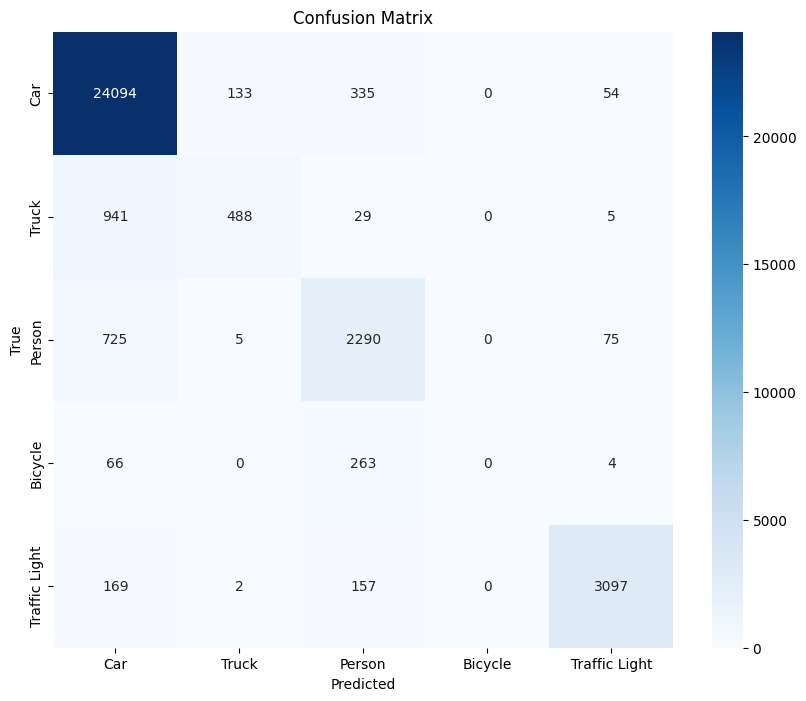


Classification Report:
               precision    recall  f1-score   support

          Car       0.93      0.98      0.95     24616
        Truck       0.78      0.33      0.47      1463
       Person       0.74      0.74      0.74      3095
      Bicycle       0.00      0.00      0.00       333
Traffic Light       0.96      0.90      0.93      3425

     accuracy                           0.91     32932
    macro avg       0.68      0.59      0.62     32932
 weighted avg       0.90      0.91      0.90     32932



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


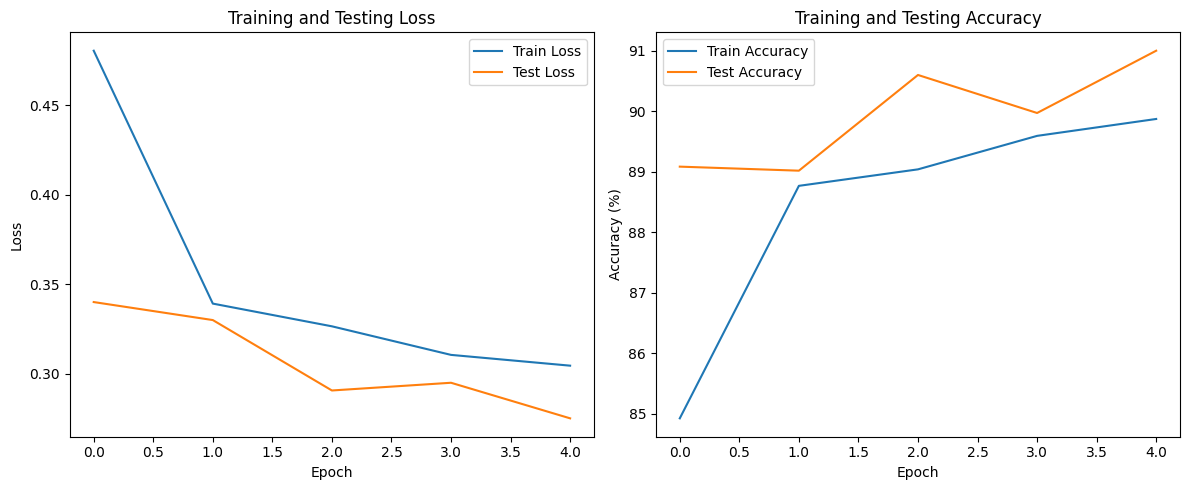


Testing random images:


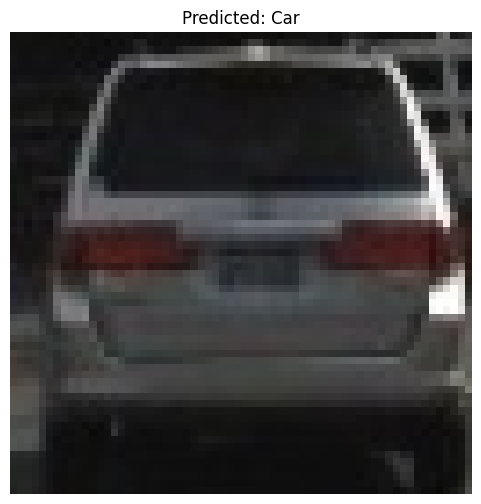

Actual: Car, Predicted: Car


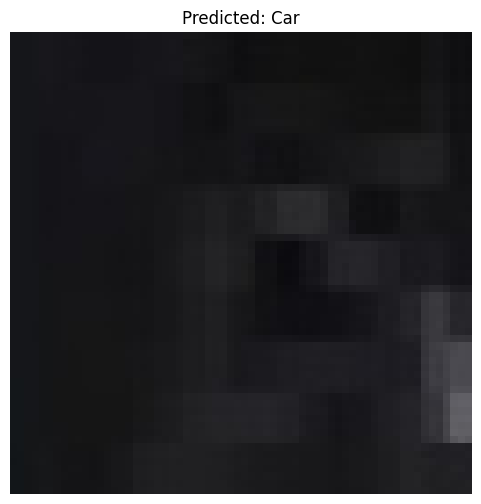

Actual: Car, Predicted: Car


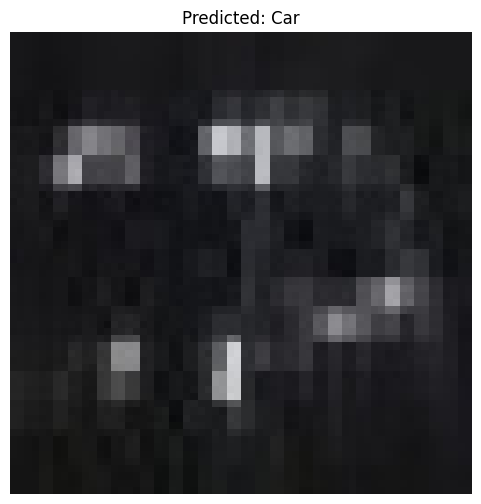

Actual: Car, Predicted: Car


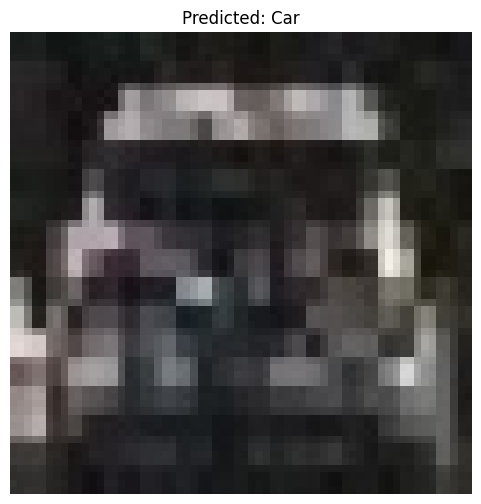

Actual: Car, Predicted: Car


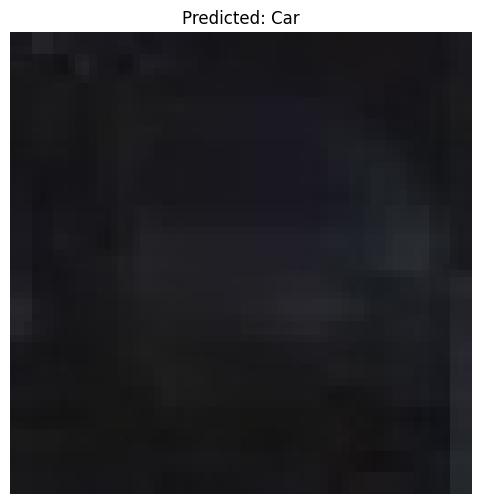

Actual: Car, Predicted: Car


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pennylane as qml
import seaborn as sns
from tqdm import tqdm
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set path to save model on Drive
SAVE_MODEL_PATH = "/content/drive/MyDrive/quantum_model.pth"
# Define constants
PROCESSED_DIR = "./processed_dataset_32x32"
BATCH_SIZE = 8
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
N_QUBITS = 4 # Number of qubits for quantum circuit

# Class mapping
class_mapping = {
    1: "Car",
    2: "Truck",
    3: "Person",
    4: "Bicycle",
    5: "Traffic Light"
}

# Custom Dataset class
class AutonomousVehicleDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert class_id to tensor
        label = torch.tensor(self.data_frame.iloc[idx, 1] - 1)  # Subtract 1 to make classes 0-indexed

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create data loaders
def get_data_loaders():
    train_dataset = AutonomousVehicleDataset(
        csv_file=os.path.join(PROCESSED_DIR, 'train.csv'),
        root_dir=PROCESSED_DIR,
        transform=train_transform
    )

    test_dataset = AutonomousVehicleDataset(
        csv_file=os.path.join(PROCESSED_DIR, 'test.csv'),
        root_dir=PROCESSED_DIR,
        transform=test_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, test_loader

# Define the quantum device and circuit
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode the classical data into quantum states
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))

    # Apply parameterized quantum circuit (strongly entangling layers)
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))

    # Measure in the computational basis
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# Feature Extractor using classical CNN
class FeatureExtractor(nn.Module):
    def __init__(self, output_dim=N_QUBITS):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Calculate the size after convolutions and pooling
        # For 64x64 input: 64 x 4 x 4 = 1024 --> changed to 64 x 8 x 8 = 4096
        # The input size to the network is 64x64.
        # After 3 pooling layers with kernel size 2, the size is 8x8.
        # With 64 output channels, the size becomes 64x8x8=4096
        self.fc = nn.Linear(64 * 8 * 8, output_dim)  # Changed input size to 4096

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
        

# Quantum Layer wrapped as PyTorch module
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits=N_QUBITS, n_layers=2):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Initialize random weights for the quantum circuit
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

# Complete Hybrid Model
class HybridQuantumModel(nn.Module):
    def __init__(self, n_classes=5, n_qubits=N_QUBITS):
        super(HybridQuantumModel, self).__init__()
        self.feature_extractor = FeatureExtractor(output_dim=n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits=n_qubits)
        self.classifier = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        classical_features = self.feature_extractor(x)
        quantum_features = self.quantum_layer(classical_features)
        output = self.classifier(quantum_features)
        return output

# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss/total,
            'acc': 100.*correct/total
        })

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return test_loss, test_acc, cm, all_preds, all_labels

# Visualize confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    plt.show()

# Plot training history
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Testing Accuracy')

    plt.tight_layout()
    plt.savefig("training_history.png")
    plt.show()

# Main function
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Get data loaders
    train_loader, test_loader = get_data_loaders()
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Testing samples: {len(test_loader.dataset)}")

    # Create model
    model = HybridQuantumModel(n_classes=len(class_mapping), n_qubits=N_QUBITS)
    model.to(device)
    print(model)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    best_test_acc = 0.0

    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # Train
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        test_loss, test_acc, cm, _, _ = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        # Save best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), SAVE_MODEL_PATH)
            print(f"Model saved with accuracy: {test_acc:.2f}%")

    print("Training complete!")

    # Load best model
    model.load_state_dict(torch.load(SAVE_MODEL_PATH))

    # Final evaluation
    _, _, cm, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Plot confusion matrix
    class_names = [class_mapping[i+1] for i in range(len(class_mapping))]
    plot_confusion_matrix(cm, class_names)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot training history
    plot_training_history(train_losses, train_accs, test_losses, test_accs)

    # Example of using the model for inference
    def test_single_image(image_path, model):
        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        image_tensor = test_transform(image).unsqueeze(0).to(device)

        # Forward pass
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = output.max(1)

        # Get class name
        predicted_class = class_mapping[predicted.item() + 1]

        # Display
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

        return predicted_class

    # Test a few random images
    print("\nTesting random images:")
    test_csv = os.path.join(PROCESSED_DIR, 'test.csv')
    test_df = pd.read_csv(test_csv)
    for _ in range(5):
        random_idx = np.random.randint(0, len(test_df))
        img_path = os.path.join(PROCESSED_DIR, test_df.iloc[random_idx, 0])
        predicted_class = test_single_image(img_path, model)
        actual_class = class_mapping[test_df.iloc[random_idx, 1]]
        print(f"Actual: {actual_class}, Predicted: {predicted_class}")

if __name__ == "__main__":
    main()

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Self-Driving Car Object Detection - User Prediction
Loading model...
Model loaded successfully. Using device: cpu

Choose an option:
1. Upload an image for prediction
2. Use an image path on the system
3. Exit
Enter your choice (1-3): 2
Enter the full path to the image: "D:\sampleperson.jpg"
File not found. Please check the path and try again.

Choose an option:
1. Upload an image for prediction
2. Use an image path on the system
3. Exit
Enter your choice (1-3): 1
Please upload an image file...


Saving trafficsignal.jpg to trafficsignal (1).jpg
Processing trafficsignal (1).jpg...


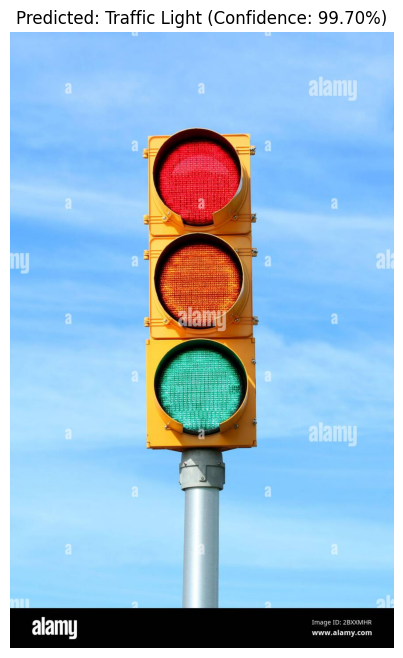


Prediction Results for trafficsignal (1).jpg:
Class: Traffic Light
Confidence: 99.70%

Probabilities for all classes:
Car: 0.02%
Truck: 0.00%
Person: 0.24%
Bicycle: 0.04%
Traffic Light: 99.70%

Choose an option:
1. Upload an image for prediction
2. Use an image path on the system
3. Exit
Enter your choice (1-3): 1
Please upload an image file...


Saving sampleperson.jpg to sampleperson (1).jpg
Processing sampleperson (1).jpg...


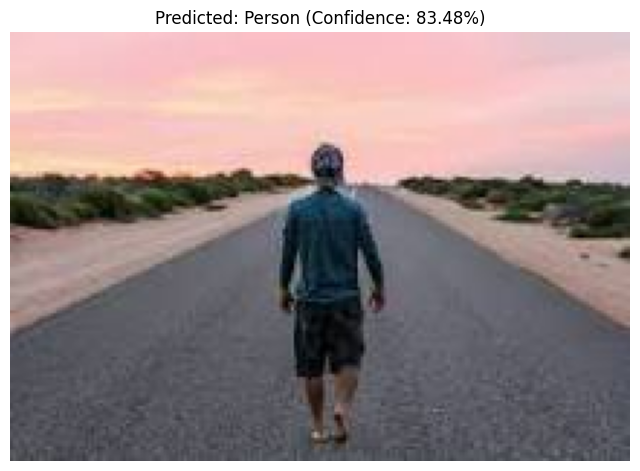


Prediction Results for sampleperson (1).jpg:
Class: Person
Confidence: 83.48%

Probabilities for all classes:
Car: 4.56%
Truck: 0.70%
Person: 83.48%
Bicycle: 8.66%
Traffic Light: 2.60%

Choose an option:
1. Upload an image for prediction
2. Use an image path on the system
3. Exit
Enter your choice (1-3): 3
Exiting the program. Goodbye!


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import pennylane as qml
import torch.nn as nn
from google.colab import files

# Define the quantum device and circuit - same as in training
N_QUBITS = 4
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode the classical data into quantum states
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))

    # Apply parameterized quantum circuit (strongly entangling layers)
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))

    # Measure in the computational basis
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# Feature Extractor using classical CNN - same as in training
class FeatureExtractor(nn.Module):
    def __init__(self, output_dim=N_QUBITS):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Calculate the size after convolutions and pooling
        # For 32x32 input: 64 x 4 x 4 = 1024
        self.fc = nn.Linear(64 * 8 * 8, output_dim)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Quantum Layer wrapped as PyTorch module - same as in training
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits=N_QUBITS, n_layers=2):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Initialize random weights for the quantum circuit
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

# Complete Hybrid Model - same as in training
class HybridQuantumModel(nn.Module):
    def __init__(self, n_classes=5, n_qubits=N_QUBITS):
        super(HybridQuantumModel, self).__init__()
        self.feature_extractor = FeatureExtractor(output_dim=n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits=n_qubits)
        self.classifier = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        classical_features = self.feature_extractor(x)
        quantum_features = self.quantum_layer(classical_features)
        output = self.classifier(quantum_features)
        return output

# Define class mapping (same as in your training code)
class_mapping = {
    1: "Car",
    2: "Truck",
    3: "Person",
    4: "Bicycle",
    5: "Traffic Light"
}

# Define image transformation (same as your test transform)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Resize to match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the model path in Google Drive
model_path = "/content/drive/MyDrive/quantum_model.pth"
def load_model(model_path="/content/drive/MyDrive/quantum_model.pth", n_classes=5, n_qubits=N_QUBITS, device=None):
    """
    Load the trained model from a saved path
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = HybridQuantumModel(n_classes=n_classes, n_qubits=n_qubits)

    # Load saved weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    return model, device

def predict_image(image_path, model, device):
    """
    Predict class for a single image
    """
    try:
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "Error: Could not load image"

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Forward pass
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Get class name and confidence
        predicted_class = class_mapping[predicted.item() + 1]
        confidence_value = confidence.item() * 100

        # Display
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class} (Confidence: {confidence_value:.2f}%)")
        plt.axis('off')
        plt.show()

        # Return prediction details
        return {
            "class": predicted_class,
            "confidence": confidence_value,
            "raw_probabilities": probabilities.cpu().numpy()[0]
        }

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

def user_input_prediction():
    """
    Function to handle user input for prediction
    """
    print("Self-Driving Car Object Detection - User Prediction")
    print("="*50)

    # Load the model
    print("Loading model...")
    try:
        model, device = load_model()
        print(f"Model loaded successfully. Using device: {device}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Make sure the quantum_model.pth file is in the current directory")
        return

    while True:
        print("\nChoose an option:")
        print("1. Upload an image for prediction")
        print("2. Use an image path on the system")
        print("3. Exit")

        choice = input("Enter your choice (1-3): ")

        if choice == '1':
            print("Please upload an image file...")
            uploaded = files.upload()

            for filename in uploaded.keys():
                print(f"Processing {filename}...")
                result = predict_image(filename, model, device)

                if result:
                    print(f"\nPrediction Results for {filename}:")
                    print(f"Class: {result['class']}")
                    print(f"Confidence: {result['confidence']:.2f}%")

                    # Show probabilities for all classes
                    print("\nProbabilities for all classes:")
                    for i, prob in enumerate(result['raw_probabilities']):
                        class_name = class_mapping[i+1]
                        print(f"{class_name}: {prob*100:.2f}%")

        elif choice == '2':
            image_path = input("Enter the full path to the image: ")
            if os.path.exists(image_path):
                result = predict_image(image_path, model, device)

                if result:
                    print(f"\nPrediction Results for {image_path}:")
                    print(f"Class: {result['class']}")
                    print(f"Confidence: {result['confidence']:.2f}%")

                    # Show probabilities for all classes
                    print("\nProbabilities for all classes:")
                    for i, prob in enumerate(result['raw_probabilities']):
                        class_name = class_mapping[i+1]
                        print(f"{class_name}: {prob*100:.2f}%")
            else:
                print("File not found. Please check the path and try again.")

        elif choice == '3':
            print("Exiting the program. Goodbye!")
            break

        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

# Run the user input prediction interface when the script is executed
if __name__ == "__main__":
    user_input_prediction()

In [ ]:
from pennylane.templates import BasicEntanglerLayers

# Just check what shape it expects (e.g., 2 layers, 4 wires)
weights = np.random.rand(2, 4)
inputs = np.random.rand(4)

try:
    print(qml.draw(quantum_circuit)(inputs, weights))
except Exception as e:


    # Try shape for StronglyEntanglingLayers: (2, 4, 3)
    weights_alt = np.random.rand(2, 4, 3)
    try:
        print(qml.draw(quantum_circuit)(inputs, weights_alt))
    except Exception as e2:
        print("❌ Still not working:", e2)


0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
[0.8353025  0.32078006 0.18651851 0.04077514]
M1 = 
[[[0.59089294 0.67756436 0.01658783]
  [0.51209306 0.22649578 0.64517279]
  [0.17436643 0.69093774 0.38673535]
  [0.93672999 0.13752094 0.34106635]]

 [[0.11347352 0.92469362 0.87733935]
  [0.25794163 0.65998405 0.8172222 ]
  [0.55520081 0.52965058 0.24185229]
  [0.09310277 0.89721576 0.90041806]]]


0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
[0.5107473  0.417411   0.22210781 0.11986537]
M1 = 
[[[0.33761517 0.9429097  0.32320293]
  [0.51879062 0.70301896 0.3636296 ]
  [0.97178208 0.96244729 0.2517823 ]
  [0.49724851 0.30087831 0.28484049]]

 [[0.03688695 0.60956433 0.50267902]
  [0.05147875 0.27864646 0.90826589]
  [0.23956189 0.14489487 0.48945276]
  [0.98565045 0.24205527 0.67213555]]]


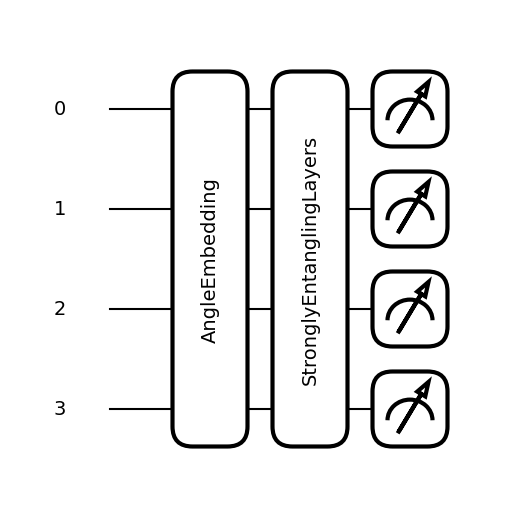

In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Dummy data with correct shapes
dummy_inputs = np.random.rand(4)
dummy_weights = np.random.rand(2, 4, 3)  # 2 layers, 4 wires, 3 parameters per wire

# Draw text-based circuit
drawer = qml.draw(quantum_circuit)
print(drawer(dummy_inputs, dummy_weights))

   